In [1]:
%load_ext autoreload
%autoreload 2


%matplotlib inline
import os

import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [8, 6]
from metavision_core.event_io import RawReader
from metavision_ml.preprocessing import histo
from metavision_ml.preprocessing.viz import viz_histo

from bounding_boxes import find_bounding_boxes
from filter_leds import filter_leds

## Configuration

In [2]:
bounding_box_size = 20

start_ts = 0.5 * 1e6  #start at 0.5 seconds
delta_t = 500  #duration in microseconds (e.g., 500 μs)

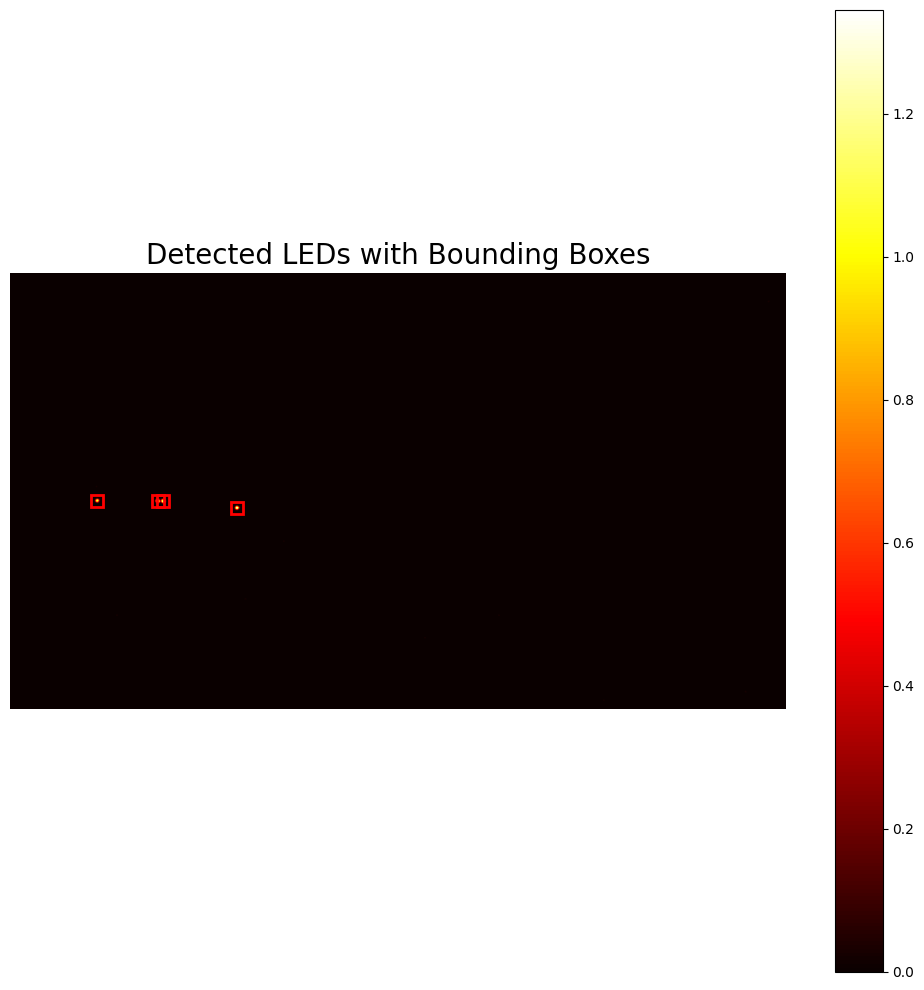

LED 1: Bounding Box Coordinates - x: 133.0, y: 366.0, width: 20.0, height: 20.0
LED 2: Bounding Box Coordinates - x: 233.0, y: 366.0, width: 20.0, height: 20.0
LED 3: Bounding Box Coordinates - x: 242.0, y: 366.0, width: 20.0, height: 20.0
LED 4: Bounding Box Coordinates - x: 364.0, y: 378.0, width: 20.0, height: 20.0


In [3]:
dir_path = ["uvled_freq_dataset", "recordings", "5k", "1", "45"]
recording_filename = "recording_2024-10-02_10-29-29.raw"
recording_path = os.path.join(*dir_path, recording_filename)

raw = RawReader(recording_path)
height, width = raw.get_size()

raw.seek_time(start_ts)

bounding_boxes = find_bounding_boxes(raw, delta_t, start_ts, height, width, bounding_box_size)

event_count_map_smoothed = bounding_boxes[1]

bounding_boxes = bounding_boxes[0]

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(event_count_map_smoothed, cmap='hot')
ax.set_title('Detected LEDs with Bounding Boxes', fontsize=20)
ax.axis('off')

for bbox in bounding_boxes:
	minc, minr, maxc, maxr = bbox
	rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr,
						fill=False, edgecolor='red', linewidth=2)
	ax.add_patch(rect)

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

for idx, bbox in enumerate(bounding_boxes):
	minc, minr, maxc, maxr = bbox
	print(f'LED {idx + 1}: Bounding Box Coordinates - x: {minc}, y: {minr}, width: {maxc - minc}, height: {maxr - minr}')


### Now load all the data from the dataset and find the bounding boxes of the images

In [4]:
#get the dataset files

dir_path = ["uvled_freq_dataset", "recordings"]
data_dirs = [
	#("__10Hz", 50),
	#("__25Hz", 50),
	#("__50Hz", 50),
	#("__100Hz", 50),
	#("__250Hz", 500),
	#("__500Hz", 500),
	("1k", 500),
	("2.5k", 500),
	("5k", 500),
	("10k", 1000),
	("20k", 1000),
	("30k", 1000)
]

directories = [d[0] for d in data_dirs]

dataset_files = []
#load the dataset files in <directories>/<subdir1>/<subdir2>/<recording>.raw
for directory in directories:
	dt = data_dirs[directories.index(directory)][1]
	for subdir1 in os.listdir(os.path.join(*dir_path, directory)):
		for subdir2 in os.listdir(os.path.join(*dir_path, directory, subdir1)):
			for recording in os.listdir(os.path.join(*dir_path, directory, subdir1, subdir2)):
				dataset_files.append((os.path.join(*dir_path, directory, subdir1, subdir2, recording), dt))


dataset_files = [file for file in dataset_files if file[0].endswith('.raw')]

for f in dataset_files:
	raw = RawReader(f[0])
	height, width = raw.get_size()

	raw.seek_time(start_ts)

	delta_t = f[1]

	bounding_boxes = find_bounding_boxes(raw, delta_t, start_ts, height, width, bounding_box_size)[0]

	save_dir = os.path.join("filtered", os.path.dirname(f[0]))

	if not os.path.exists(save_dir):
		os.makedirs(save_dir)

	save_path = os.path.join(save_dir, os.path.basename(f[0]))

	filter_leds(f[0], bounding_boxes, save_path)